### 1. Initial exploration

In [1]:
from datasets import load_dataset

dataset_dict = load_dataset("PolyAI/banking77")
df_train = dataset_dict["train"].to_pandas()
df_test = dataset_dict["test"].to_pandas()

df_train["text"] = df_train["text"].str.strip()
df_test["text"] = df_test["text"].str.strip()

In [2]:
print(f"Train dataset size: {len(df_train)}") 
print(f"Test dataset size: {len(df_test)}") 

Train dataset size: 10003
Test dataset size: 3080


In [3]:
print("Schema:")
print(df_train.dtypes)

Schema:
text     object
label     int64
dtype: object


In [4]:
df_train.head(10)

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
5,When did you send me my new card?,11
6,Do you have info about the card on delivery?,11
7,What do I do if I still have not received my n...,11
8,Does the package with my card have tracking?,11
9,I ordered my card but it still isn't here,11


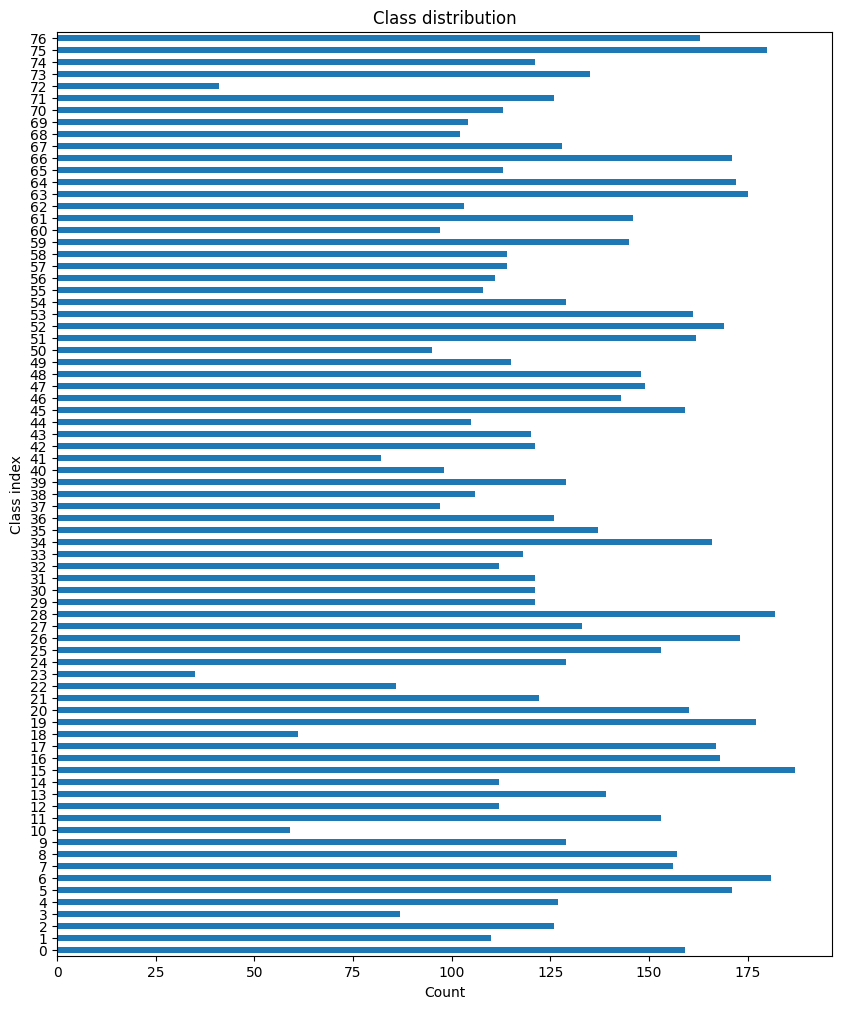

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12)) 
(
    df_train["label"]
    .value_counts()
    .sort_index()
    .plot.barh(x="label", y="len", ax=ax)
)

plt.title("Class distribution")
plt.xlabel("Count")
plt.ylabel("Class index")
plt.show()

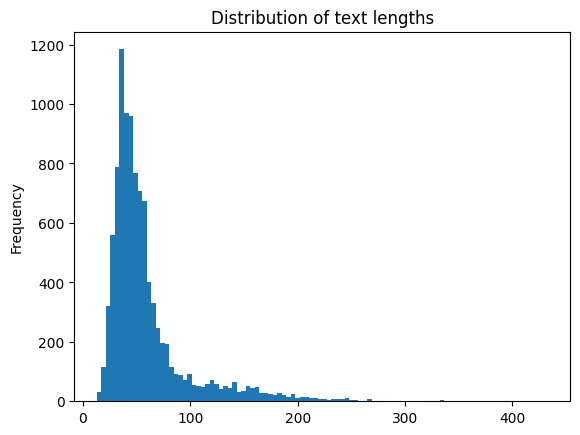

In [6]:
df_train["text"].str.len().plot.hist(y="text_length", bins=100)
plt.title("Distribution of text lengths")
plt.show()

In [7]:
(df_train["text"].str.len() == 0).sum()

0

There are no empty texts, nan values or any other immediately visible mistakes in dataset.

### 2. Data Quality issues

Creating text embeddings

In [8]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

train_texts = df_train["text"].to_numpy()
test_texts = df_test["text"].to_numpy()

train_labels = df_train["label"].to_numpy()
test_labels = df_test["label"].to_numpy()

train_embeddings = embedding_model.encode(train_texts)
test_embeddings = embedding_model.encode(test_texts)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

pred_probs = cross_val_predict(LogisticRegression(class_weight="balanced"), train_embeddings, train_labels, method='predict_proba')

Running cleanlab

In [12]:
import os
from cleanlab import Datalab

os.environ["TOKENIZERS_PARALLELISM"] = "false"

texts = df_train["text"].to_numpy()
data_dict = {"text": texts, "label": df_train["label"].to_numpy()}
lab = Datalab(data_dict, label_name="label", task="classification")
lab.find_issues(pred_probs=pred_probs, features=train_embeddings)
lab.report()

Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 648 issues found in the dataset.
Dataset Information: num_examples: 10003, num_classes: 77

Here is a summary of various issues found in your data:

    issue_type  num_issues
near_duplicate         350
         label         166
       outlier         131
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


------------------ near_duplicate issues -------------------

About this issue:
	A (near) duplicate issue refers to two or more examples in
    a dataset that are extremely similar to each other, relative
  

### Duplicates

In [13]:
duplicate_issues = lab.get_issues("near_duplicate")
duplicate_issues = duplicate_issues[duplicate_issues["is_near_duplicate_issue"]]
duplicate_issues = duplicate_issues.sort_values(by="near_duplicate_score")

Top Score duplicates

In [14]:
for idx, row in duplicate_issues.head(10).iterrows():
    text = texts[idx]
    neighbors = texts[row["near_duplicate_sets"][:3]]

    print(text == neighbors[0])
    print(f"Text: {text}")
    print(f"Duplicates: {neighbors}")
    print()

True
Text: I put the wrong pin too many times and now it is blocked. Can you help me unblock it?
Duplicates: ['I put the wrong pin too many times and now it is blocked. Can you help me unblock it?']

True
Text: I can't seem to be able to use my card
Duplicates: ["I can't seem to be able to use my card"]

True
Text: I can't seem to be able to use my card
Duplicates: ["I can't seem to be able to use my card"]

True
Text: Where can I withdraw money from?
Duplicates: ['Where can I withdraw money from?']

True
Text: Where can I withdraw money from?
Duplicates: ['Where can I withdraw money from?']

False
Text: How can I reset my passcode?
Duplicates: ['How can i reset my passcode ?' 'How do I reset my passcode?']

False
Text: How can i reset my passcode ?
Duplicates: ['How can I reset my passcode?' 'How do I reset my passcode?']

True
Text: I put the wrong pin too many times and now it is blocked. Can you help me unblock it?
Duplicates: ['I put the wrong pin too many times and now it is bloc

Lower score duplicates

In [15]:
for idx, row in duplicate_issues.tail(10).iterrows():
    text = texts[idx]
    neighbors = texts[row["near_duplicate_sets"][:3]]

    print(text == neighbors[0])
    print(f"Text: {text}")
    print(f"\tDuplicates: {neighbors}")
    print()

False
Text: What should I do if I can't prove my identity.
	Duplicates: ["What do I do if I can't prove my identity?"]

False
Text: How can I receive a virtual card?
	Duplicates: ['How do I receive a virtual card?']

False
Text: How do I receive a virtual card?
	Duplicates: ['How can I receive a virtual card?']

False
Text: Can you please tell me why my transfer failed?
	Duplicates: ['Can you please explain why my transfer failed?']

False
Text: Can you please explain why my transfer failed?
	Duplicates: ['Can you please tell me why my transfer failed?']

False
Text: Is there a limit to a disposable virtual card?
	Duplicates: ['Is there a limit to using a disposable virtual card?']

False
Text: Is there a limit to using a disposable virtual card?
	Duplicates: ['Is there a limit to a disposable virtual card?']

False
Text: Can I top up any amount?
	Duplicates: ['Can I top-up any amount?']

False
Text: Can I top-up any amount?
	Duplicates: ['Can I top up any amount?']

False
Text: How lo

It is quite evident that most of the texts that are supposedly duplicate are either exactly the same od differ only by some whitespace characters, or single words that do not change the meaning of the sentence. I think its sensible to remove them.

In [16]:
original_texts = set()
duplicated_texts = set() # Set containing texts to remove from dataset

for idx, row in duplicate_issues.iterrows():
    original_texts.add(idx) # Keep one example from the group of duplicates

    for neighbor in row["near_duplicate_sets"]:
        if neighbor not in original_texts: # If neighbor is already marked as original then it should not be removed
            duplicated_texts.add(neighbor) # Otherwise mark as `to remove`

In [17]:
import numpy as np

duplicates = np.array(list(duplicated_texts))
df_deduplicated = df_train.drop(duplicates, inplace=False)
df_deduplicated

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
...,...,...
9998,You provide support in what countries?,24
9999,What countries are you supporting?,24
10000,What countries are getting support?,24
10001,Are cards available in the EU?,24


#### Mislabelings

To correctly identify the labeling issues it would be useful to read the class descriptions instead of just operating on indexes.

In [18]:
import pandas as pd

label_desc = pd.read_csv("label_desc.tsv", sep=r"[\t ]+", header=0)
label_desc = label_desc.set_index("label")

In [19]:
label_desc

,label_desc
label,
0,activate_my_card
1,age_limit
2,apple_pay_or_google_pay
3,atm_support
4,automatic_top_up
...,...
72,virtual_card_not_working
73,visa_or_mastercard
74,why_verify_identity


In [20]:
label_issues = lab.get_issues("label")
label_issues = label_issues[label_issues["is_label_issue"]]
label_issues = label_issues.sort_values(by="label_score")

In [21]:
top_label_issues_y_true = label_desc.loc[label_issues.head(10)["given_label"]]
top_label_issues_y_pred = label_desc.loc[label_issues.head(10)["predicted_label"]]

top_label_issues_idxs = label_issues.head(10).index
top_label_issues_texts = texts[top_label_issues_idxs]

print("Top 10 label issues")
for text, y_true, y_pred in zip(top_label_issues_texts, top_label_issues_y_true['label_desc'], top_label_issues_y_pred['label_desc']):
    print(f"True class: {y_true}\nPred class: {y_pred}\nText: {text}\n")

Top 10 label issues
True class: pending_top_up
Pred class: topping_up_by_card
Text: i put money on my card and i dont see it on the balance

True class: disposable_card_limits
Pred class: getting_virtual_card
Text: i am not a premium customer but i want a virtual card, how do i get it

True class: declined_cash_withdrawal
Pred class: card_not_working
Text: Is my card actually working? It's the first time I tried using it

True class: transfer_into_account
Pred class: topping_up_by_card
Text: How do I top up?

True class: top_up_failed
Pred class: declined_card_payment
Text: My credit card transaction was declined for a loan payment.  Can you tell me why?

True class: pending_transfer
Pred class: balance_not_updated_after_bank_transfer
Text: I have not seen any changes in my account balance(s) after making a transfer.

True class: lost_or_stolen_card
Pred class: card_arrival
Text: Can you tell me the status of my new card?

True class: transfer_timing
Pred class: balance_not_updated_aft

The cause of the wrong labeling we can observe from cleanlab analysis aligns with the conclusion from the paper that analysed the banking77 dataset. The issue is that some of the classes might overlap and its not entirely obvious to which should one example be assigned to. I will apply label corrections based on cleanlab's algorithm proposals.

In [22]:
label_issues = label_issues.loc[label_issues.index.isin(df_deduplicated.index)]
df_deduplicated.loc[label_issues.index, 'label'] = label_issues['predicted_label']

#### Outliers

In [23]:
outlier_issues = lab.get_issues("outlier")
outlier_issues = outlier_issues[outlier_issues["is_outlier_issue"]].sort_values(by="outlier_score")

top_outliers = outlier_issues.head(10)

In [24]:
for index in top_outliers.index:
    print(f"Review: {texts[index]}, label: {label_desc.loc[train_labels[index]]['label_desc']}")

Review: WHAT IS THE ATMOSPHERE OF IT, label: card_acceptance
Review: what is the word?, label: direct_debit_payment_not_recognised
Review: What is this witdrawal, label: cash_withdrawal_not_recognised
Review: what is the matter?, label: direct_debit_payment_not_recognised
Review: WHAT IS THE SOLUTION OF THIS PROBLEM, label: card_arrival
Review: I prefer Mastecard., label: visa_or_mastercard
Review: I have made 5 attempts to make a very standard survey, yet I can't get it to work. What is the problem? Is there an issue related to your system?, label: failed_transfer
Review: WHAT IS THE MAIN REASON OF THIS PROBLEM, label: card_not_working
Review: WHAT IS THE REASON FOR THAT, label: card_not_working
Review: why was i chargged, label: transfer_fee_charged


Many of the outliers seem to be written in uppercase letters. However changing all texts to lowercase might not be good either, for example word `PIN` that occurs in the examples would change to `pin` and completely change the meaning. For now I think its better to leave the outliers as they are.

#### Non IID

There was also a single, mysterious non_iid example, I think the there is no reason to suspect any correlation between the texts, but let's check this anyway.

In [25]:
non_iid = lab.get_issues("non_iid")
non_iid = non_iid[non_iid['is_non_iid_issue']]

In [26]:
print(texts[non_iid.index])
print(label_desc.loc[train_labels[non_iid.index]]['label_desc'])

['how do i track the moeney']
label
70    verify_source_of_funds
Name: label_desc, dtype: object


I guess it can stay.

In [27]:
df_fixed = df_deduplicated.reset_index(drop=True)

### 3. Predictive Model training

In [28]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

valid_size = int(0.2 * len(df_fixed))
df_train, df_valid = train_test_split(df_fixed, test_size=valid_size, random_state=0, stratify=df_fixed["label"])

datasets_dict = DatasetDict()
datasets_dict["train"] = Dataset.from_pandas(df_train, split="train")
datasets_dict["valid"] = Dataset.from_pandas(df_valid, split="valid")
datasets_dict["test"] = Dataset.from_pandas(df_test, split="test")

In [ ]:
import torch
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def tokenize(examples: dict) -> dict:
    encoded_examples = tokenizer(examples["text"], padding=True, truncation=True)
    encoded_examples["label"] = torch.tensor(examples["label"])
    return encoded_examples

datasets_tokenized = datasets_dict.map(tokenize, batched=True)

In [31]:
import os
import random

from sklearn.metrics import matthews_corrcoef
from torch.nn.functional import softmax
from transformers import AutoModelForSequenceClassification, EvalPrediction, Trainer, TrainingArguments


os.environ["PYTHONHASHSEED"] = str(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.mps.manual_seed(0)


model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=77)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
model = AutoModelForSequenceClassification.from_pretrained("finetuned_banking_model/checkpoint-19000") # Reading from previous training

In [34]:
# freeze some weights to speed up training
for param in model.distilbert.embeddings.parameters():
    param.requires_grad = False

for param in model.distilbert.transformer.parameters():
    param.requires_grad = False


from sklearn.metrics import f1_score

def compute_metrics(eval_pred: EvalPrediction) -> dict:
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    f1 = f1_score(labels, preds, average="macro")
    return {"f1": f1}


training_args = TrainingArguments(
    output_dir="finetuned_banking_model",
    learning_rate=1e-3,
    num_train_epochs=20,
    eval_strategy="steps",
    save_steps=1000,
    eval_steps=1000,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=0,
    data_seed=0,
    fp16=False,
    bf16=True,
    dataloader_num_workers=1,
    use_mps_device=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets_tokenized["train"],
    eval_dataset=datasets_tokenized["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# trainer.train()

### 4. Model Testing

In [35]:
predictions = trainer.predict(datasets_tokenized["test"])
probas = torch.tensor(predictions.predictions).softmax(dim=1).numpy()
y_pred = np.argmax(predictions.predictions, axis=1)
y_test = df_test["label"].to_numpy()

In [39]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, accuracy_score

f1_macro = f1_score(y_test, y_pred, average="macro")
print(f"Macro F1-score: {f1_macro:.4f}")

y_true_bin = label_binarize(y_test, classes=np.arange(77))
auroc = roc_auc_score(y_true_bin, probas, multi_class="ovo")
print(f"Multiclass AUROC: {auroc:.4f}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy:.4f}")

Macro F1-score: 0.8116
Multiclass AUROC: 0.9954
Accuracy score: 0.8123


In [40]:
f1_per_class = f1_score(y_test, y_pred, average=None)

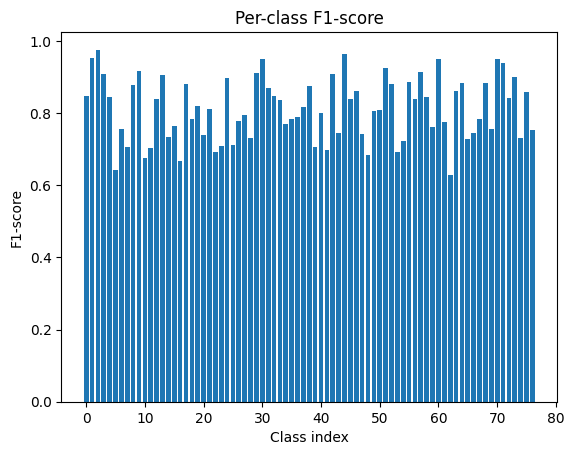

In [41]:
plt.bar(range(len(f1_per_class)), f1_per_class)
plt.xlabel("Class index")
plt.ylabel("F1-score")
plt.title("Per-class F1-score")
plt.show()

In [ ]:
f1_per_class.max(), f1_per_class.min()

(0.975609756097561, 0.6285714285714286, 2)

In [51]:
label_desc.loc[f1_per_class.argmax()], label_desc.loc[f1_per_class.argmin()]

(label_desc    apple_pay_or_google_pay
 Name: 2, dtype: object,
 label_desc    topping_up_by_card
 Name: 62, dtype: object)

In the paper the authors achieved the accuracy of 0.882 and f1-score of 0.878 with LightGBM classifier, and better results 0.924 accuracy and 0.920 f1 on a trimmed and cleaned dataset. Mine results are about 7% lower on both on those metrics. From my perspective the results seem fine. There f1 score across classes varies significantly, from about 0.628 to 0.975, it is apparent that that some classes contain higher quality data than others. The class with the worst f1 score is 'topping_up_by_card', this was also mentioned in the paper that this particular class has issues.

### 5. Giskard

In [52]:
from giskard import Model as GiskardModel, Dataset as GiskardDataset, scan, testing
from transformers import pipeline

trained_model = trainer.model
trained_model.eval()

model_pipeline = pipeline(
    "text-classification", 
    model=trained_model, 
    tokenizer=tokenizer,
    device="mps" if torch.backends.mps.is_available() else "cpu",
    top_k=None
)

@torch.no_grad()
def prediction_function(df: pd.DataFrame) -> np.ndarray:
    pred_output = model_pipeline(df["text"].tolist())
    y_pred_proba = np.zeros((len(pred_output), len(pred_output[0])))

    for idx, prediction in enumerate(pred_output):
        for single_pred in prediction:
            label_str = single_pred["label"]
            try:
                label_idx = int(label_str.split("_")[-1])  # In case label_str looks like 'LABEL_32' -> 32
            except:
                label_idx = int(label_str) # If label_str looks like '32' -> 32
            y_pred_proba[idx, label_idx] = single_pred["score"]
            
    return y_pred_proba

Device set to use mps


In [53]:
giskard_dataset = GiskardDataset(df_test, target="label")

giskard_model = GiskardModel(
    model=prediction_function,
    model_type="classification",
    classification_labels=list(range(77)),
    feature_names=["text"],
)
scan_results = scan(giskard_model, giskard_dataset, verbose=False)
display(scan_results)

2025-11-19 15:11:12,741 pid:29853 MainThread giskard.datasets.base INFO     Your 'pandas.DataFrame' is successfully wrapped by Giskard's 'Dataset' wrapper class.
2025-11-19 15:11:12,742 pid:29853 MainThread giskard.models.automodel INFO     Your 'prediction_function' is successfully wrapped by Giskard's 'PredictionFunctionModel' wrapper class.
2025-11-19 15:11:12,754 pid:29853 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-19 15:11:13,063 pid:29853 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (10, 2) executed in 0:00:00.316677
2025-11-19 15:11:13,067 pid:29853 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-19 15:11:13,079 pid:29853 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1, 2) executed in 0:00:00.014430
2025-11-19 15:11:13,082 pid:29853 MainThread giskard.datasets.base 

<iframe id="scan-18675350608" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:co

### 6. Captum

In [54]:
from copy import deepcopy

from captum.attr import InputXGradient, configure_interpretable_embedding_layer
from captum.attr import visualization as vis


class BERTModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs, attention_mask):
        return self.model(inputs, attention_mask=attention_mask)[0]


def explain_text(model, text: str, y_true: int) -> None:

    for param in model.distilbert.parameters():
        param.requires_grad = True
    
    tokenizer_output = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    tokenizer_output = tokenizer_output.to(device)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer_output["input_ids"][0])

    model_copy = deepcopy(model)
    interpretable_embedding_layer = configure_interpretable_embedding_layer(
        model_copy, "distilbert.embeddings"
    )

    input_embeddings = interpretable_embedding_layer.indices_to_embeddings(
        tokenizer_output["input_ids"]
    )

    model_wrapper = BERTModelWrapper(model_copy)
    input_x_gradient = InputXGradient(model_wrapper)
    attributions = input_x_gradient.attribute(
        input_embeddings,
        target=y_true,
        additional_forward_args=tokenizer_output["attention_mask"],
    )

    # mean normalization
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = list([float(attr) for attr in attributions])
    
    with torch.no_grad():
        logits = model(**tokenizer_output).logits
        probs = softmax(logits, dim=1)[0]
        y_pred_class = torch.argmax(probs).item()
        y_pred_proba = probs[y_pred_class].item() 

    # remove [CLS] and [SEP] tokens
    attributions = attributions[1:-1]
    tokens = tokens[1:-1]

    true_class_proba = probs[y_true]
    
    vis_record = vis.VisualizationDataRecord(
        word_attributions=attributions,
        pred_prob=y_pred_proba,
        pred_class=y_pred_class,
        true_class=y_true,
        attr_class=f"{true_class_proba:.2f}",
        attr_score=sum(attributions),
        raw_input_ids=tokens,
        convergence_score=0,
    )
    vis.visualize_text([vis_record])


In [55]:

for class_idx in [0, 11, 22, 33, 44]:
    print(f"Class description: {label_desc.loc[class_idx, 'label_desc']}")

    for idx, row in df_test[df_test['label'] == class_idx].head(3).iterrows():
        explain_text(trainer.model, row["text"], y_true=class_idx)

    print("===========================\n")

Class description: activate_my_card


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.87),0.87,-0.40,could you please activate my card


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.93),0.93,-0.17,i need to activate my card can you do that now ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.98),0.98,0.33,what do i need to do to activate my new card ?



Class description: card_arrival


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
11,11 (0.60),0.60,-1.09,how do i locate my card ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
11,11 (0.73),0.73,-0.09,"i still have not received my new card , i ordered over a week ago ."


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
11,41 (0.67),0.13,-0.02,i ordered a card but it has not arrived . help please !



Class description: compromised_card


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
22,22 (0.93),0.93,0.98,i think someone is using my card to make transactions i don ' t remember .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
22,55 (0.51),0.05,0.89,someone is using my account


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
22,22 (0.98),0.98,1.45,someone i don ' t know has used my card without permission .



Class description: exchange_via_app


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
33,33 (0.38),0.38,0.29,may i exchange cu ##rre ##ncies with this ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
33,33 (0.82),0.82,-0.55,tell me how i can exchange between different currency .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
33,33 (0.84),0.84,0.74,can i change from one currency to another ?



Class description: passcode_forgotten


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
44,44 (0.99),0.99,-0.75,what do i do if i forget my pass ##code ? because i did .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
44,44 (0.98),0.98,-0.38,i can ' t find my password


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
44,44 (0.88),0.88,-1.07,how do i retrieve my pass ##code ?


For many cases the highlighted words seem to be relevant, like card activation, in other cases its less obvious what really happened, also there are some examples when model predicted a wrong label like in text `someone is using my account` the predicted label was 55 which is `terminate_account` instead of `compromised_card`, the highlight in that case was put on the word `someone`